# PDHG Non-cartesian
This notebook applies the PDHG algorithm on a non-cartesian mask based on the paper "Learning the Sampling Pattern for MRI" published in June 2019. More details on the functions (and especially on the proximal operators) can be found there.

## Imports

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN ,FFT
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
from pysap.utils import save_image

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold,Ridge

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from PIL import Image
from modopt.math.matrix import PowerMethod

## Inputs

In [3]:
u0 = get_sample_data('2d-mri')

# Obtain MRI non-cartesian mask
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, u0.shape))

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [229]:
mask.show()

### Test for creation of a mask from scratch (no import)

In [4]:
#Random mask
n=3000
new_kspace_loc = np.empty((n,2))
for i in range(n):
    new_kspace_loc[i]=[rd.random()-0.5,rd.random()-0.5]

In [7]:
m = convert_locations_to_mask(new_kspace_loc,(512,512))
newmask = pysap.Image(data=m)
newmask.show()

### Data
Observations: $y=S\mathcal{F}Ru+\epsilon$.

In [8]:
#Original image
image_rec0 = pysap.Image(data=np.abs(u0))
image_rec0.show()

In [9]:
# Adding noise
(n1,n2) = u0.shape
sigma = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = fourier_op.op(u0.data)
y += np.asarray([np.random.normal(0,sigma)+np.random.normal(0,sigma)*1j for i in range(len(y))])
u0_mat = np.asarray(u0)

p=np.asarray([1 for i in range(len(y))])
pn1 = 1e-8
y *= p
y_temp = np.copy(y)

In [12]:
# Generate operators
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)
# linear_op = WaveletN(
#     wavelet_name='sym8',
#     nb_scale=4)

In [13]:
# Tools for inverse fft
grid_space = np.linspace(-0.5, 0.5, num=u0.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)

In [14]:
# Base reconstructed image: computes an inverse fft according to the mask on the noised data
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
image_rec0 = pysap.Image(data=np.abs(grid_soln))
image_rec0.show()

In [9]:
ssim(grid_soln,u0)

0.6450384065624448

$\textbf{Remarque:}$ On a deja un gros écart en amplitude entre cette reconstruction à l'ordre 0 et l'image initiale avec le masque radial ($10^{-5}$ contre $10^{-8}$).

# Definition of functions to compute energy
Since S is a nxn diagonal matrix, we won't store it in memory and do all the computations directly with p

In [59]:
#constants
zeta = 1e10
epsilon = 1e-3
gamma = 1e-10
beta = 100

In [16]:
# functions B and G in the paper
def b(u):
    return np.sum([np.sum([max(0,-z**3)for z in u[i]]) for i in range(len(u))])*zeta
def g(u):return np.real(b(u)+epsilon*np.linalg.norm(u)**2/2)

In [17]:
# functions J and F2 in the paper
# We also compute rho and its first derivative since we will need it later
def rho(x):
    m = np.absolute(x)
    if m<gamma:
        return -m*m*m/3/gamma/gamma+m*m/gamma
    else:
        return m-gamma/3
def drho(x):
    if x<-gamma:return -1
    elif x<0:return x**2/gamma**2+2*x/gamma
    elif x<gamma:return -x**2/gamma**2+2*x/gamma
    else:return 1
    

def j(u):
    if len(u.shape)==1:
        return np.sum([rho(x) for x in u])
    else:
        return np.sum([np.sum([rho(x) for x in y])for y in u])
def f2(w): return pn1*j(w)

In [18]:
#function F1 in the paper
def R(u):
    return np.asarray([[np.real(u[i][j]) for j in range(len(u[0]))]for i in range(len(u))])
def Rstar(u):
    return np.array([[u[i][j]+0j for j in range(len(u[0]))]for i in range(len(u))])
def f1(v):
    return 0.5*np.linalg.norm((fourier_op.op(Rstar(v))-y)*p)**2

In [19]:
#PENALTY
def P(p):
    return beta*np.sum([[x*(2-x) for x in p[i]]for i in range(len(p))])

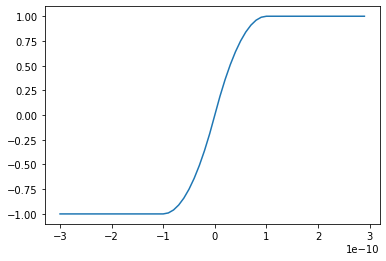

In [20]:
#First derivative of rho around 0
t = [0.1*i*gamma for i in range(-30,30)]
plt.plot(t,[drho(x) for x in t])

In [21]:
def energy(u):
    return(f1(Rstar(u))+f2(linear_op.op(u))+g(u))

In [22]:
print(energy(np.zeros(u0_mat.shape)))
print(energy(u0_mat))
print(energy(2*u0_mat))

0.0005596378959801517
4.3266786830432376e-08
0.0005595634601310919


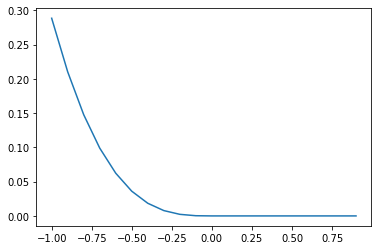

In [23]:
plt.plot([i/10 for i in range(-10,10)],[g(i*u0_mat/10) for i in range(-10,10)])

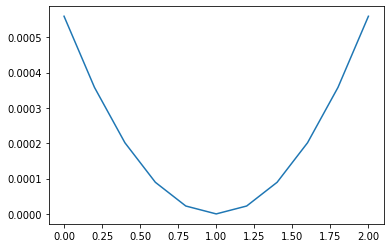

In [27]:
plt.plot([i/5 for i in range(11)],[energy(i*u0_mat/5)for i in range(11)])

# Proximal operators
The objective is to find the point minimizing $f_u(x) = F(x)+1/2||x-u||^2$ for a given u and for $F=\tau F1,\tau F2,\tau G$ where $\tau$ is a given constant.
## Proximal operator of F2
We want to minimize $f_u(x) = \tau\alpha (p)J(|x|)+\frac{1}{2}||x-u||^2$. As explained in the paper, given the definition of J, we can compute the solution component by component, but the paper expresses $x_i$ in terms of $u_i$ with a constant C that we need to compute. We have in 1D $f_u'(x) = \tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$. Since $\rho '(x)$ depends on if $|x|<\gamma$ or not, we need to separate these two cases:
### |x|>$\gamma$
In this case, $\rho '(|x|)=1$, so we simply have $(1+\frac{\tau\alpha(p)}{|x|})x=u\Rightarrow x=(|u|-\tau\alpha(p))\frac{u}{|u|}$. Since we supposed $|x|<\gamma$ beforehand, this will be true when $|u|>\tau\alpha(p)+\gamma$.
### |x|$\leq\gamma$
From what we just saw, this is equivalent to $|u|\leq\tau\alpha(p)+\gamma$. This case is a bit more complicated, since now $\rho '(|x|)=-\frac{|x|^2}{\gamma^2}+2\frac{|x|}{\gamma}$ and taking the norm on both sides of $\tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$ gives us:
$$-\frac{\tau\alpha(p)}{\gamma^2}|x|^2+(1+\frac{2\tau\alpha(p)}{\gamma})|x|-|u|=0\\
\Rightarrow |x| = \gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1\pm\sqrt{\Delta})\\
with\ \Delta=1+\frac{4\tau\alpha(p)}{\gamma^2}(\gamma+\tau\alpha(p)-|u|)$$
But since we want $|x|<\gamma$, the only acceptable solution is $x=\left(\gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1-\sqrt{\Delta})\right)\frac{u}{|u|}$. Since $|u|\leq\tau\alpha(p)+\gamma$, we see that $\Delta>1$, so the condition $|x|\leq\gamma$ is verified.

## Proximal operator of F1
The expression given in the paper is:
$$prox_{\tau F1}(u) = \mathcal{F}(I+\tau S(p)^2)^{-1}(\mathcal{F}u+\tau S(p)^2y)$$
with y the data.\\
I find a different value when I recompute it: we want to minimize $f_u(x) = \frac{1}{2}\tau||S(p)(\mathcal{F}x-y)||+\frac{1}{2}||x-u||^2$. When we differentiate, we get:
$$f_u(x+h) = f_u(x)+\tau <S(p)\mathcal{F}h,S(p)(\mathcal{F}u-y)> + <h,(x-u)>+o(||h||)$$
Since S(p) is diagonal, we have:
$$f_u(x+h)-f_u(x) = <\mathcal{F}h,\tau S(p)^2(\mathcal{F}u-y)>+<h,x-u>+o(||h||)\\
\Rightarrow \nabla f_u(x) = \mathcal{F}^{-1}\left[\tau S(p)^2(\mathcal{F}u-y)\right]+x-u$$
Finally, I find $prox_{\tau F_1}(u) = u-\mathcal{F}^{-1}\left[\tau S(p)^2(\mathcal{F}u-y)\right] = \mathcal{F}^{-1}\left[(I-\tau S(p)^2)\mathcal{F}u+\tau S(p)^2y\right]$


## Proximal dual operators
We use the Moreau identity to compute the proximal dual operators:
$$prox_{\gamma\phi ^*}(x) = x-\gamma prox_{\phi/\gamma}(\frac{x}{\gamma})$$

In [28]:
#Prox_tauG
def prox_B(u,c):
    return np.asarray([[x/(0.5+np.sqrt(0.25-3*zeta*c*min(0,x)))for x in u[i]]for i in range(len(u))])
def prox_G(u,c):
    return prox_B(u/(1+epsilon),c/(1+epsilon))

In [467]:
c=50
y1 = prox_G(-0.1*u0_mat,c)
y2 = y1+np.asarray([[np.random.normal(0,1e-7)for i in range(n2)]for j in range(n1)])

r1 = c*g(y1)+0.5*np.linalg.norm(u0_mat-y1)**2
r2 = c*g(y2)+0.5*np.linalg.norm(u0_mat-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):"
                  ,np.abs(r1)/np.abs(r2))

Distance between the two points: 5.12154387821974e-05
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.017802560287458195


In [29]:
#Prox_tau/F2
def prox_F2(u,c):
    n = len(u)
    v = np.asarray([0+0j for i in range(n)])
    for i in range(n):
        mod_u = np.abs(u[i])
        if mod_u>c*pn1+gamma:
            v[i] = (mod_u-c*pn1)*u[i]/np.abs(u[i])
        else:
            delta = 1+4*c*pn1/(gamma**2)*(gamma+c*pn1-mod_u)
            v[i] = (gamma+gamma**2/(2*c*pn1)*(1-np.sqrt(delta)))*u[i]/np.abs(u[i])
    return v
def prox_F2_dual(u,c):
    return u-c*prox_F2(u/c,1/c)

In [17]:
c=2
x = np.asarray([1,2,3,4])
y1 = prox_F2(x,c)
y2 = y1+np.asarray([np.random.normal(0,1e-4)for i in range(4)])

r1 = c*f2(y1)+0.5*np.linalg.norm(x-y1)**2
r2 = c*f2(y2)+0.5*np.linalg.norm(x-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):",r1/r2)

Distance between the two points: 0.00016569607747124205
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.9999942799268857


In [30]:
#prox_tauF1
def prox_F1_paper(u,c):
    im=(fourier_op.op(u)+c*p*p*y)/(np.ones(y.shape)+c*p*p)
    return gridded_inverse_fourier_transform_nd(kspace_loc,im,tuple(grid2D),'linear')

def prox_F1(u,c):
    im = c*p*p*(fourier_op.op(u)-y)
    return u-gridded_inverse_fourier_transform_nd(kspace_loc, im,
                                                 tuple(grid2D), 'linear')

def prox_F1_dual(u,c):
    return u-c*prox_F1(u/c,1/c)


In [421]:
c=6
k=1
y1 = prox_F1(k*u0_mat,c)
y2 = y1+np.asarray([[np.random.normal(0,1e-6)for i in range(n2)]for j in range(n1)])
y3 = prox_F1_paper(u0_mat,c)


r1 = c*f1(y1)+0.5*np.linalg.norm(k*u0_mat-y1)**2
r2 = c*f1(y2)+0.5*np.linalg.norm(k*u0_mat-y2)**2
r3 = c*f1(y3)+0.5*np.linalg.norm(k*u0_mat-y3)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):",r1/r2)

Distance between the two points: 0.0005118717344431965
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.17330281804864242


# Test with only one regulariser
We only use F1 and G.
Utiliser undecimated pour linear_op pour comparer a Condat-Vu.

In [60]:
#constants
L=5
eta = 1
mu = 2*np.sqrt(epsilon/(1+L*L)/eta)
tau = mu/2/epsilon
sigma = mu*eta/2
theta = 1/(1+mu)

maxit = 20
tol = 1e-4

In [61]:
def step_test(uk,vk,uk_bar):
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    uk1 = prox_G(uk-tau*R(vk1),tau)
    uk_bar1 = uk1+theta*(uk-uk1)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk))/(np.linalg.norm(vk))
    return uk1,vk1,uk_bar1,norm

In [62]:
#initialisation
n_iter = 0
uk = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
image_rec0 = pysap.Image(data=np.abs(uk))
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [63]:
vk = np.copy(uk)
wk = linear_op.op(u0_mat)
uk_bar = np.copy(uk)
norm = 2*tol
energies = []
norms = []

print("Base ssim:",ssim(uk,u0_mat), "\nBase cost:", energy(uk))
while n_iter<100:
    uk,vk,uk_bar,norm = step_test(uk,vk,uk_bar)
    n_iter += 1
    energies.append(f1(uk)+g(uk))
    norms.append(norm)
    print(n_iter," iterations:\nCost:",f1(uk)+g(uk),"\nssim:",ssim(uk,u0_mat),"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

Base ssim: 0.6489807567408439 
Base cost: 0.0005559192712636503
1  iterations:
Cost: 0.0005389674488618788 
ssim: 0.7193763639319817 
Norm: 5.074610610462129 

2  iterations:
Cost: 0.0005093083992541233 
ssim: 0.6376382652506446 
Norm: 3.2720494937318536 

3  iterations:
Cost: 0.00047902625611152827 
ssim: 0.6403404509231905 
Norm: 1.473147925555046 

4  iterations:
Cost: 0.00045105397419739206 
ssim: 0.637656327560314 
Norm: 0.9265410307549944 

5  iterations:
Cost: 0.0004260680263400022 
ssim: 0.6179869205126369 
Norm: 0.6644285741391849 

6  iterations:
Cost: 0.000403912840513535 
ssim: 0.5995453264159772 
Norm: 0.5048322758665181 

7  iterations:
Cost: 0.0003844064801003548 
ssim: 0.5854566054209868 
Norm: 0.3992356646267402 

8  iterations:
Cost: 0.0003674151595948877 
ssim: 0.574706690477997 
Norm: 0.32729827786048243 

9  iterations:
Cost: 0.0003528542756758508 
ssim: 0.56624542025982 
Norm: 0.2770632789069851 

10  iterations:
Cost: 0.00034057967510959776 
ssim: 0.5596899423319

83  iterations:
Cost: 0.0002253192951115808 
ssim: 0.46176232421262664 
Norm: 0.012672806912207565 

84  iterations:
Cost: 0.00022446856212337573 
ssim: 0.4614857568286604 
Norm: 0.012430115981417201 

85  iterations:
Cost: 0.0002236418595312953 
ssim: 0.46120441818126756 
Norm: 0.01208228179294229 

86  iterations:
Cost: 0.00022283675711967733 
ssim: 0.46091746687729535 
Norm: 0.01165349237445533 

87  iterations:
Cost: 0.00022205063680741616 
ssim: 0.46062468819192465 
Norm: 0.011174844942000321 

88  iterations:
Cost: 0.00022128056969585144 
ssim: 0.4603259039944492 
Norm: 0.010682293788871207 

89  iterations:
Cost: 0.0002205236755547863 
ssim: 0.46002169451618596 
Norm: 0.010216306820393688 

90  iterations:
Cost: 0.00021977722155940637 
ssim: 0.4597108025341324 
Norm: 0.009818760647080742 

91  iterations:
Cost: 0.0002190385571113805 
ssim: 0.4593926403074719 
Norm: 0.009524215179465622 

92  iterations:
Cost: 0.00021830504264509155 
ssim: 0.45906744766580754 
Norm: 0.00935017076

In [240]:
print("Valeur de la fonction de cout en u0:",f1(u0_mat)+g(u0_mat))

Valeur de la fonction de cout en u0: 5.200205388503879e-08


In [51]:
#Final image
image_rec = pysap.Image(data=np.abs(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.6524097364972687


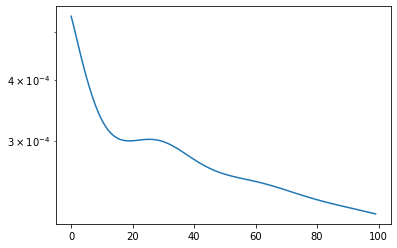

In [64]:
plt.plot(energies)
plt.yscale("log")

# Implementation of the PDHG algorithm

In [37]:
#constants
L=5
eta = max(np.amax(p)**2,pn1*j(np.reshape(u0_mat,(n1*n2,1))))
mu = 2*np.sqrt(epsilon/(1+L*L)/eta)
tau = mu/2/epsilon
sigma = mu*eta/2
theta = 1/(1+mu)

maxit = 20
tol = 1e-4

In [38]:
def step(uk,vk,wk,uk_bar):
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    wk1 = prox_F2_dual(wk+sigma*linear_op.op(uk_bar),sigma)
    uk1 = prox_G(uk-tau*R(vk1)-tau*linear_op.adj_op(wk1),tau)
    uk_bar1 = uk1+theta*(uk-uk1)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk))
    return uk1,vk1,wk1,uk_bar1,norm

In [39]:
#initialisation
n_iter = 0
uk = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
image_rec0 = pysap.Image(data=np.abs(uk))
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [40]:
vk = np.copy(uk)
wk = linear_op.op(u0_mat)
uk_bar = np.copy(uk)
norm = 2*tol
print("Base ssim:",ssim(uk,u0_mat), "\nBase cost:", energy(uk))
while n_iter<15 and norm>tol:
    uk,vk,wk,uk_bar,norm = step(uk,vk,wk,uk_bar)
    n_iter += 1
    print(n_iter," iterations:\nCost:",energy(uk),"\nssim:",ssim(uk,u0_mat),"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

Base ssim: 0.6489807567408439 
Base cost: 0.0005559192714338876
1  iterations:
Cost: 0.0005457901900165798 
ssim: 0.21684053835958073 
Norm: 3.065591020336996 

2  iterations:
Cost: 0.0005329424256907362 
ssim: 0.24960176888611235 
Norm: 1.4527600228402604 

3  iterations:
Cost: 0.0005202388444210074 
ssim: 0.2884781738373614 
Norm: 0.6562455096256699 

4  iterations:
Cost: 0.0005080128970873927 
ssim: 0.31516173230900574 
Norm: 0.4003542940111786 

5  iterations:
Cost: 0.000496311270491126 
ssim: 0.33543484953943825 
Norm: 0.28984198194919014 

6  iterations:
Cost: 0.0004851516668442366 
ssim: 0.35317395807198204 
Norm: 0.23654175698117955 

7  iterations:
Cost: 0.00047453469192710755 
ssim: 0.3713275551320515 
Norm: 0.2071133480417054 

8  iterations:
Cost: 0.00046444755383969697 
ssim: 0.39211035155773877 
Norm: 0.18864545979654695 

9  iterations:
Cost: 0.0004548687928217819 
ssim: 0.41680436078287614 
Norm: 0.17592909999460601 

10  iterations:
Cost: 0.00044577266163829893 
ssim: 

In [41]:
#Final image
image_rec = pysap.Image(data=np.abs(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.6310714958184727


In [430]:
g(uk)

3.733876860322817e-09

## Convergence

In [104]:
t = [i for i in range(11)]
uk = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
vk = np.copy(uk)
wk = linear_op.op(u0_mat)
uk_bar = np.copy(uk)
ssims = [ssim(uk,u0)]
norms = []
energies = []
for i in range(20):
    uk1,vk1,wk1,uk_bar,norm = step(uk,vk,wk,uk_bar)
    norms.append(np.linalg.norm(uk1-uk)/np.linalg.norm(uk)+
                 (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk)))
    uk,vk,wk = uk1,vk1,wk1
    ssims.append(ssim(uk,u0))
    energies.append(energy(uk))
    print("iterations completed: ",i+1)

iterations completed:  1
iterations completed:  2
iterations completed:  3
iterations completed:  4
iterations completed:  5
iterations completed:  6
iterations completed:  7
iterations completed:  8
iterations completed:  9
iterations completed:  10
iterations completed:  11
iterations completed:  12
iterations completed:  13
iterations completed:  14
iterations completed:  15
iterations completed:  16
iterations completed:  17
iterations completed:  18
iterations completed:  19
iterations completed:  20


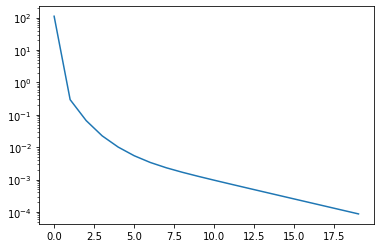

In [105]:
plt.plot(norms)
plt.yscale("log")

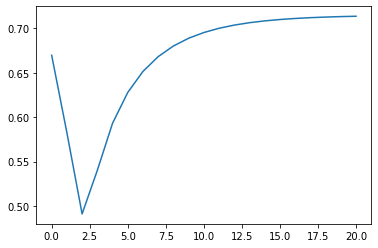

In [106]:
plt.plot([t for t in range(21)],ssims)

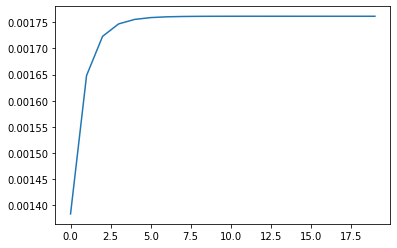

In [107]:
plt.plot(energies)

Tester avec operateur fourier correspondant au gradient de F1 pour tester avec algos pysap. Passer partie reelle des donnees. Proximity_combo dans modopt pour somme des prox.

In [108]:
#Final image
image_rec0 = pysap.Image(data=np.abs(uk))
print(ssims[-1])
image_rec0.show()

0.7136793909835487


# Comparison to other optimization algorithms

In [223]:
f = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
f.op = lambda x:fourier_op.op(np.real(x))
#Adj_op correct? Necessaire?
f.adj_op = lambda x:fourier_op.adj_op(np.real(x))

In [224]:
regularizer_op = Ridge(Identity(), epsilon, thresh_type="soft")
reconstructor = SingleChannelReconstructor(
    fourier_op=f,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=0,
)

In [225]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=f.op(u0_mat),
    optimization_alg='condatvu',
    num_iterations=100,
)

100% (100 of 100) |######################| Elapsed Time: 0:01:10 Time:  0:01:10


In [226]:
image_CV = pysap.Image(data=np.abs(x_final))
recon_ssim = ssim(image_CV, u0)
image_CV.show()
print(recon_ssim)

0.6162060092618351


In [227]:
f1(np.asarray(image_CV))+g(np.asarray(image_CV))

8.010380723625084e-06